## Image Registration using Finite Rate of Innovation Sampling

In this notebook we will demonstrate our method for registering smFISH images by aligning weighted spikes corresponding to the fluorescent markers in the images. 

In [80]:
import matplotlib.pyplot as plt
import collections
from itertools import combinations,product
from functools import reduce
from scipy.ndimage.interpolation import rotate, shift
from scipy.ndimage.filters import convolve
from scipy.misc import imresize
from skimage import color,io,data
import numpy as np
from ipywidgets import FloatProgress
from IPython.display import display
import time
%matplotlib inline

from skimage.morphology import white_tophat
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

### Plot Images Function

In [81]:
def plot_images(imgs,dim1,dim2,color = 'gray'):
    '''
    plots a list of images [imgs] in a grid of dimensions dim1 * dim2
    color must be a valid cmap value for plt.imshow
    '''
    
    Nimgs = len(imgs)
    if Nimgs != (dim1*dim2):
        raise ValueError('There are',Nimgs,'images. Please enter correct dimensions')
    plt.figure(figsize=(20,20))
    for n in range(Nimgs):
        plt.subplot(dim1,dim2,n+1)
        plt.imshow(imgs[n], cmap=color)
    return

### Import Images

In [82]:
def import_images(path_to_images):
    raw_imgs = []
    for i in range(1,5):
        collection = io.imread_collection([path_to_images+str(i)+'/c2.TIF',path_to_images+str(i)+'/c3.TIF', \
                                           path_to_images+str(i)+'/c4.TIF',path_to_images+str(i)+'/c5.TIF'])
        #plot_images(collection,1,len(collection))
        raw_imgs.append(np.array(collection))

    dots = io.imread(path_to_images+'DO/c2.TIF')
    #plot_images([dots],1,1)
    return raw_imgs,dots

### Maximum Intensity Projection

This function performs a maximum intensity projection across all color channels. It output a list of images, each image corresponding to one hybridization round. 

In [83]:
def maximum_intensity_projection(raw_imgs):
    img_set = []
    for imgs in raw_imgs:
        img = np.maximum.reduce(imgs)
        img_set.append(img)
    #plot_images(img_set,1,len(img_set))
    return img_set

### Apply White Tophat Filter

This function applies a White Top Hat filter to locate fluorescent markers in the input images as well as the reference "dots" image.

In [84]:
def filter_images(img_set,dots):
    filtered_imgs = []

    for img in img_set:
        filtered = white_tophat(img)
        filtered[filtered < 25] = 0
        filtered_imgs.append(filtered)
    
    #plot_images(filtered_imgs,2,2)

    filtered_dots = white_tophat(dots)
    filtered_dots[filtered_dots < 50] = 0
    #plot_images([filtered_dots],1,1)
    
    return filtered_imgs,filtered_dots

### Extract Dot Locations and Intensities

This function extracts the location of the fluorescent markers from the filtered images.

In [85]:
def find_diracs(filtered_dots,filtered_imgs):

    dot_locations = []
    dot_intensities = []

    for img in filtered_imgs:
        x,y = np.where(img > 0)
        locations = np.transpose(np.vstack((x,y))) 
        intensities = img[img > 0]
        dot_locations.append(locations)
        dot_intensities.append(intensities)

    x,y = np.where(filtered_dots > 0)
    reference_locations = np.transpose(np.vstack((x,y)))
    reference_intensities = filtered_dots[filtered_dots > 0]

    return dot_locations, dot_intensities, reference_locations, reference_intensities

### DBSCAN Clustering

Each fluorescent marker is several pixels large. This function finds the single pixel location that best represents each fluorescent marker. 

In [86]:
def cluster(dot_locations, dot_intensities, reference_locations, reference_intensities):

    centroids = []
    reference = []

    for i in range(len(dot_locations)):
        model = DBSCAN(eps=3)
        labels = model.fit_predict(dot_locations[i],sample_weight = dot_intensities[i])
        img_centroids = []
        for j in range(np.amax(labels)):
            c = np.average(dot_locations[i][labels==j],axis=0,weights = dot_intensities[i][labels==j])
            img_centroids.append(c)
        centroids.append(np.array(img_centroids))

    model = DBSCAN(eps=3)
    labels = model.fit_predict(reference_locations,sample_weight = reference_intensities)
    for j in range(np.amax(labels)):
        c = np.average(reference_locations[labels==j],axis=0, weights= reference_intensities[labels==j])
        reference.append(c)

    reference = np.array(reference)
    
    return centroids, reference


This function is simply used to visualize the single pixel "centroids" in each image.

In [87]:
def print_centroid_images(centroids,reference):
    
    centroid_imgs = []
    for i in range(len(centroids)):
        centroid_img = np.zeros_like(img_set[i])
        for j in centroids[i]:
            centroid_img[tuple(np.around(j).astype(int))] = 255
        centroid_imgs.append(centroid_img)
    
    reference_img = np.zeros_like(filtered_dots)
    for j in reference:
        reference_img[tuple(np.around(j).astype(int))] = 255
    
    plot_images(centroid_imgs,2,2)
    plot_images([reference_img],1,1)

### Register Images

This function finds the shifts necessary to align the spikes in a misaligned image to the spikes in the reference image. 

In [88]:
def register_dots(reference,image,search_range):
    
    tree = cKDTree(reference)
    distances = tree.query(image)[0]
    img = image[distances<=search_range]
    shifts = np.random.randint(-search_range,search_range,2)
    
    checked_x = []
    checked_y = []
    
    while(abs(shifts[0]) <= search_range and abs(shifts[1])<= search_range):
        
        shifted_image = img + shifts
        distances = tree.query(shifted_image)[0]
        cost = np.sum(np.square(distances))
        
        ##Don't recompute values that have already been checked
        checked_x.append(shifts[0])
        checked_y.append(shifts[1])
        
        ##Check neighbors
        
        directions = np.array([[1,1],[1,0],[1,-1],[0,1],[0,-1],[-1,1],[-1,0],[-1,-1]])
        costs = []
        for i in directions:
            if (shifts[0] + i[0] in checked_x) and (shifts[1] + i[1] in checked_y):
                costs.append(np.inf)
                continue
            shifted_image = img + shifts + i
            distances = tree.query(shifted_image)[0]
            costs.append(np.sum(np.square(distances)))
        
        costs = np.array(costs)
        min_cost = np.amin(costs)
        
        if min_cost < cost:
            shifts = shifts + directions[np.argmin(costs)]
        
        else:
            return shifts
        


This function takes in a list of images in the following format:

(hybridization rounds, color channels, X_dim, Y_dim) 

It also takes in a single reference "dots" image.

The function returns the shifts necessary to align each input image (corresponding to each hybridization round) with the the reference image.

In [89]:
def register_images(images,reference):
    
    img_set = maximum_intensity_projection(images)
    filtered_imgs, filtered_dots = filter_images(img_set,reference)
    dot_loc, dot_int, ref_loc, ref_int = find_diracs(filtered_dots,filtered_imgs)
    centroids,reference = cluster(dot_loc,dot_int,ref_loc,ref_int)
    
    search_range = 50
    start = time.time()
    shifts = []
    for i,img in enumerate(centroids):
        s = register_dots(reference,img,search_range)
    
        if np.amax(abs(s))*2 < search_range:
            new_range = min(np.amax(abs(s))*2,search_range)
            new_s = register_dots(reference,img,new_range)
            s = new_s
    
        shifts.append(s)
        print('Image %d Shifts: ' %i)
        print(s)

    end = time.time()
    print('Total time:',end-start)
    
    return shifts

### Main

Test image registration using finite rate of innovation sampling.

In [102]:
path_to_images = './raw_images/ExampleInSituSequencing/'
images,ref = import_images(path_to_images)
shifts = register_images(images,ref)

Image 0 Shifts: 
[-3 11]
Image 1 Shifts: 
[ 1 -3]
Image 2 Shifts: 
[-5  0]
Image 3 Shifts: 
[-6 -1]
Total time: 0.358842134475708


Test image registration using cross-correlation.

In [98]:
from skimage.feature import register_translation

img_set = maximum_intensity_projection(images)
start = time.time()

for i,img in enumerate(img_set):
    corr_shifts = register_translation(ref,img)[0]
    print('Image %d Shifts: ' % i)
    print(corr_shifts)
    
end = time.time()
print('Total time',end-start)

Image 0 Shifts: 
[-3. 11.]
Image 1 Shifts: 
[ 2. -3.]
Image 2 Shifts: 
[-5.  0.]
Image 3 Shifts: 
[-6. -1.]
Total time 0.7282280921936035


We can ensure that our method computes the correct shifts by visually inspecting the images.

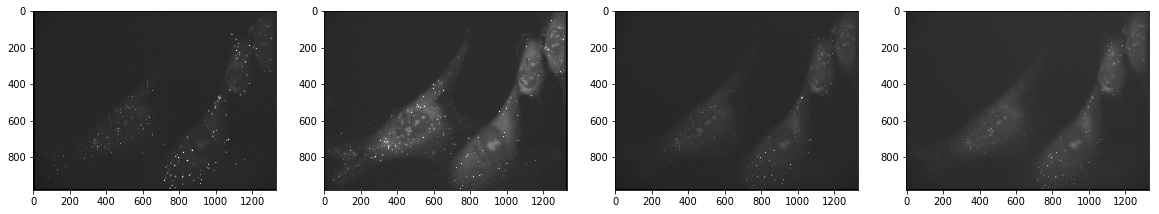

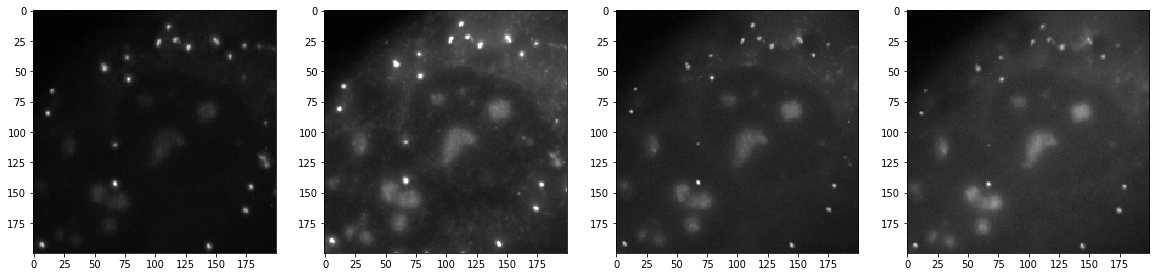

In [99]:
shifted_images = []
zoomed_images = []

for i,img in enumerate(img_set):
        shifted_images.append(shift(img,shifts[i]))
        
for img in shifted_images:
    zoomed_images.append(img[500:700,400:600])

plot_images(shifted_images,1,len(shifted_images))
plot_images(zoomed_images,1,len(zoomed_images))